## **IMPORT** per MILP dimensionamento economico-ambientale degl impatti dei leganti inorganici

In [9]:
using Pkg
Pkg.add("JuMP");
Pkg.add("HiGHS");
Pkg.add("DataFrames");
Pkg.add("CSV");
Pkg.add("Plots");

using JuMP, HiGHS, DataFrames, CSV, Plots;

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [122]:
using Printf

# toyModel

## descrizione

Ho queste variabili:
* Una variabile continua Xij, che rappresenta il numero di anime "i = {1, ... 200}" prodotte in materiale "j = {1 = organico, 2 = inorganico}.
* Una variabile binaria Yij = {1 se attivo la produzione dell'anima i nel materiale j, 0 altrimenti}.

Ogni anima viene prodotta per una famiglia di prodotti sola. Ogni famiglia di prodotti "riceve" più anime.

Ho i seguenti parametri:
* Qij, che mi dice quanto inquina un'anima i in materiale j ([100, 5])
* Uik, che mi indica quante anime di tipo i servono per la famiglia di prodotto k
* Pk, che mi indica quanti prodotti k produciamo k = {1...14}
* Cj, che mi indica il costo di uno stampo per un'anima di prodotto j ([3k, 60k])

Ho i seguenti vincoli:
* Un vincolo di produzione (tante anime quante mi servono)
* Non posso stampare in un materiale se non ho pagato lo stampo
* Posso inquinare massimo "tot" (che varia per avere la frontiera di pareto)

Ho la seguente funzione obiettivo:
* minimizzare i costi, dati solo dallo stampo

### Quindi le cose fatte sono state:


Importare i dati:
- $Q_{ij}$
- $U_{ik}$
- $P_{k}$
- $C_{j}$


mettere i vincoli:
- $$
\sum_{j}(X_{ij}) \geq \sum_{k}(U_{ik} \cdot P_{k}), \ \ \ \ \forall i
$$

- $$
X_{ij} \leq Y_{ij} \cdot \sum_{k}(U_{ik} \cdot P_{k}), \ \ \ \ \forall i \ \ \forall j
$$

- $$
\sum_{i}\left(\sum_{j}(Q_{j} \cdot X_{ij})\right) \leq
L \cdot \sum_{i}\left(\sum_{k}(U_{ik} \cdot P_{k} \cdot Q_{i1})\right) + (1-L) \cdot \sum_{i}\left(\sum_{k}(U_{ik} \cdot P_{k} \cdot Q_{i2})\right)
$$


funzione obiettivo:
- $$
\min \sum_{i}\left(\sum_{j}(C_{k} \cdot Y_{ij})\right)
$$

ottimizzare - ottimizzo con L che varia. L è il parametro del terzo vincolo, che impone un livello permesso di inquinamento sempre più basso: il sistema quindi spende più soldi per fare meno emissioni

*** Note:
* aggiungere la cosa delle macchine da adattare in base alla pressione produttiva?
* mettere la decadenza degli stampi?

## implementazione

In [213]:
L = 1
na = 14 #numero anime
nm = 2 #numero materiali

Q = [100, 5] # [fill(100, na) fill(5, na)] #Qij che non riesco a importarlo, però è [100, 5] per le 200 anime
C = [3000, 60000] #Cj
P = Matrix(CSV.read("Pk.csv", DataFrame, header = false))[:,1];  #Pk
U = Matrix(CSV.read("Uik.csv", DataFrame, header = false)); #Uik

In [ ]:
toyModel = Model(HiGHS.Optimizer)

@variable(toyModel, X[1:na, 1:2] >= 0)
@variable(toyModel, Y[1:na, 1:2], Bin)

@constraint(toyModel, [i in 1:na], sum(X[i, j] for j in 1:2) .>= (U*P)[i]);
@constraint(toyModel, [i in 1:na, j in 1:2], X[i, j] .<= Y[i, j]*(U*P)[i]);
@constraint(toyModel, inquinamento, sum(sum(X[i, j] for i in 1:na)*Q[j] for j in 1:2) .<= L*sum(U*P*Q[1]) + (1-L)*sum(U*P*Q[2]));

@objective(toyModel, Min, sum(sum(Y[i, j]*C[j] for j in 1:2) for i in 1:na));

vett_y = [] #qui le emissioni
vett_x = [] #qui i soldi spesi
for L in 1:-0.1:0
  set_normalized_rhs(inquinamento, L*sum(U*P*Q[1]) + (1-L)*sum(U*P*Q[2]))
  optimize!(toyModel)
  push!(vett_x, objective_value(toyModel))
  push!(vett_y, sum(sum(value(X[i,j]) for i in 1:na)*Q[j] for j in 1:2))
  # per bloccare il ciclo quando un modello è infeasible: "termination_status(toyModel) == MOI.INFEASIBLE"
end



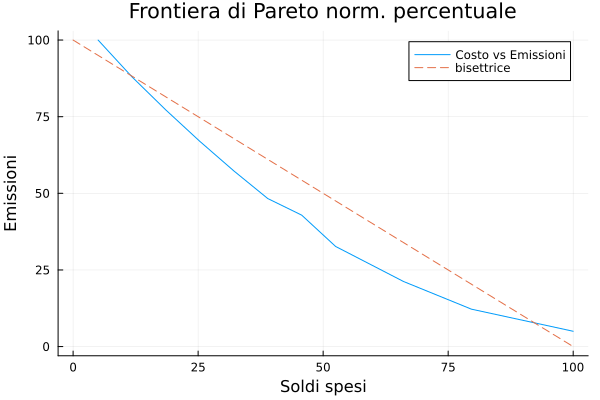

In [218]:


'''
plot(100*vett_x/maximum(vett_x), 100*vett_y/maximum(vett_y),
    aspect_ratio=:equal,
    xlabel="Soldi spesi",
    ylabel="Emissioni",
    title="Frontiera di Pareto norm. ratio",
    label="Costo vs Emissioni",
    legend=:topright)
'''

plot(vett_x, vett_y,
    xlabel="Soldi spesi",
    ylabel="Emissioni",
    title="Frontiera di Pareto norm. percentuale",
    label="Costo vs Emissioni",
    legend=:topright)


plot(100*vett_x/maximum(vett_x), 100*vett_y/maximum(vett_y),
    xlabel="Soldi spesi",
    ylabel="Emissioni",
    title="Frontiera di Pareto norm. percentuale",
    label="Costo vs Emissioni",
    legend=:topright)
    plot!(x_ticks, 100 .- x_ticks, label="bisettrice", linestyle=:dash)

altri vincoli che possono essere aggiunti sono:

Xij >= Zij (Vi Vj) dove Zij è un intero che mi indica quanti stampi ho acquistato per quel tipo (poi si integrerà con una componente di costo)

Si(Xi2)/(portata) >= m per l'acquisto di nuove macchine (eventuale vendita di quelle vecchie?) che possano stampare il materiale 2

volendo si può aggiungere il peso dell'anima per: inquinare in base al peso; avere un costo di mancato recupero della terra soffiata

# sandModel

## descrizione

### Ho queste variabili:
* Una variabile continua $X_{ij}$, che rappresenta il numero di anime "i = {1, ... na}" prodotte in materiale "j = {1 = organico, 2 = inorganico}.
* Una variabile intera $Y_{ij}$, che rappresenta quanti stampi ho acquistato per l'anima i in materiale j
* una variabile intera $K$, che mi indica quante macchine devo adattare alla produzione di anime inorganiche

### Ho i seguenti parametri, che importo
* $Q_{ij}$ che mi dice quanto inquina un'anima i in materiale j
* $U_{ik}$ che mi indica quante anime di tipo i servono per la famiglia di prodotto k
* $P_{k}$ che mi indica quanti prodotti k produciamo k = {1...14}
* $C_{j}$ che mi indica il costo di uno stampo per un'anima di prodotto j ([3k, 60k])
* $m$ che mi indica il numero delle macchine
* $I$ mi indica quanto costa adattare una macchina oer fare stampi inorganici
* $V$ è il numero di cicli che uno stampo può durare
* $Q_{ij}$ può essere una funzione del peso $W_{i}$ (non modifica i vincoli ma solo la funzione di costo)

quindi
* $ \sum_{k} (U_{ik} \cdot P_{k}) $  mi indica la produzione richiesta per anima di tipo i, e la chiamo $P_{i}$
* $\sum_{i}(P_{i})$ la chiamo $P_{TOT}$
* $P_{TOT}/m $ sono le unità che ogni macchina produce in media in un anno. questa quantità la chiamo $M$

### funzione obiettivo: minimizzare i costi

- $ \min \left(\sum_{i}\left(\sum_{j}(\cdot C_{k} \cdot Y_{ij})\right) + I \cdot k\right)$


### Ho 4 gruppi di  vincoli:
1. Un vincolo di produzione (produco tante anime quante mi servono)

  $ \sum_{j}(X_{ij}) \geq P_{i} \ \ \ \ \ \ \forall i $

2. un vincolo sul ciclo vita degli stampi

  $ X_{ij} \leq V \cdot Y_{ij} \ \ \ \ \ \ \ \ \forall i \ \ \forall j $

3. un vincolo sull'adattamento delle macchine

  $ \sum_{i}(X_{i2}) \leq k \cdot M $

4. un vincolo sull'inquinamento, con L per la combinazione convessa per Pareto

  $ \sum_{i}\left(\sum_{j}(Q_{ij} \cdot X_{ij})\right) \leq
L \cdot \sum_{i} (P_{i} \cdot Q_{i1}) + (1-L) \cdot \sum_{i} (P_{i} \cdot Q_{i2})  $



## implementazione

il modello, per qualche cazzo di motivo, non sta andando lol sono molto irritata

In [219]:
# import
L = 1 #peso
na = 14 #numero anime
np = 14 #numero famiglie prodotto
nm = 2 #numero materiali
m = 2#numero macchine

V = 10_000 #ciclo vita degli stampi
I = 600_000 #costo di adattamento di una macchina

C = [3000, 60000] #Cj
Q = Matrix(CSV.read("Qij.csv", DataFrame, header = false)); #Qij
U = Matrix(CSV.read("Uik.csv", DataFrame, header = false)); #Uik
p = Matrix(CSV.read("Pk.csv", DataFrame, header = false))[:,1];  #Pk

P = U * p; #così è Pi
Ptot = sum(P);
M = Ptot / m; #M produzione standard di una macchina

Yub = maximum(P)/V;
Kub = m;

In [243]:
# Definizione del modello
sandModel = Model(HiGHS.Optimizer)
set_silent(sandModel)

set_optimizer_attribute(sandModel, "mip_rel_gap", 1e-2) # Set relative MIP gap tolerance to a lower value
#set_optimizer_attribute(sandModel, "mip_abs_gap", 0.0)  # Set absolute MIP gap tolerance to zero
#set_optimizer_attribute(sandModel, "mip_feas_tol", 1e-9) # Set feasibility tolerance for MIP to a lower value

set_optimizer_attribute(sandModel, "presolve", "on") # Enable presolve
#set_optimizer_attribute(sandModel, "solver", "ipm") # Set the solver to IPM
set_time_limit_sec(sandModel, 10.0) # Set time limit for HiGHS


# Definizione delle variabili
@variable(sandModel, X[1:na, 1:2] >= 0)  # Variabile continua
@variable(sandModel, 0<= Y[1:na, 1:2] <= Yub+1, Int)  # Variabile intera positiva
@variable(sandModel, K >=0 , Int)  # Variabile intera positiva

# Vincoli
@constraint(sandModel, prod[i in 1:na], sum(X[i, j] for j in 1:2) >= P[i])
@constraint(sandModel, mold[i=1:na, j=1:2], X[i, j] <= V * Y[i, j])
@constraint(sandModel, machine, sum(X[i, 2] for i in 1:na) <= K * M )
@constraint(sandModel, pollution, sum(Q[i, j] * X[i, j] for i in 1:na, j in 1:2) <= L * sum(P[i] * Q[i, 1] for i in 1:na) + (1 - L) * sum(P[i] * Q[i, 2] for i in 1:na))

# Funzione obiettivo
@objective(sandModel, Min, sum(C[j] * Y[i, j] for i in 1:na, j in 1:2) + I*K)

# Risoluzione del problema
#optimize!(sandModel)

## Risultati
#println("Costo minimo: ", objective_value(sandModel))
#println("Valori di X: ", value.(X))
#println("Valori di Y: ", value.(Y))
#println("Valori di K: ", value.(K))

vett_y_sm = [] #qui le emissioni
vett_x_sm = [] #qui i soldi spesi
vett_k_sm = []
for L in 1:-0.01:0
  set_normalized_rhs(pollution, L * sum(P[i] * Q[i, 1] for i in 1:na) + (1 - L) * sum(P[i] * Q[i, 2] for i in 1:na))


  optimize!(sandModel)
  push!(vett_x_sm, objective_value(sandModel))
  push!(vett_y_sm, sum(Q[i, j] * value(X[i, j]) for i in 1:na, j in 1:2))
  push!(vett_k_sm, value(K))
  println("Istanza ", L, "      Gap: ", @sprintf("%.0e%%", 100 * relative_gap(sandModel)),"     K = ", value(K))
#  println("MIP gap: ", relative_gap(sandModel))
#  println("K: ", value(K))
  #println(objective_value(sandModel))
  # per bloccare il ciclo quando un modello è infeasible: "termination_status(toyModel) == MOI.INFEASIBLE"
end


Istanza 1.0      Gap: 0e+00%     K = -0.0
Istanza 0.99      Gap: 0e+00%     K = 1.0
Istanza 0.98      Gap: 0e+00%     K = 1.0
Istanza 0.97      Gap: 0e+00%     K = 1.0
Istanza 0.96      Gap: 0e+00%     K = 1.0
Istanza 0.95      Gap: 0e+00%     K = 1.0
Istanza 0.94      Gap: 0e+00%     K = 1.0
Istanza 0.93      Gap: 0e+00%     K = 1.0
Istanza 0.92      Gap: 0e+00%     K = 1.0
Istanza 0.91      Gap: 0e+00%     K = 1.0
Istanza 0.9      Gap: 0e+00%     K = 1.0
Istanza 0.89      Gap: 4e-01%     K = 1.0
Istanza 0.88      Gap: 0e+00%     K = 1.0
Istanza 0.87      Gap: 0e+00%     K = 1.0
Istanza 0.86      Gap: 0e+00%     K = 1.0
Istanza 0.85      Gap: 0e+00%     K = 1.0
Istanza 0.84      Gap: 4e-01%     K = 1.0
Istanza 0.83      Gap: 0e+00%     K = 1.0
Istanza 0.82      Gap: 0e+00%     K = 1.0
Istanza 0.81      Gap: 0e+00%     K = 1.0
Istanza 0.8      Gap: 4e-01%     K = 1.0
Istanza 0.79      Gap: 0e+00%     K = 1.0
Istanza 0.78      Gap: 0e+00%     K = 1.0
Istanza 0.77      Gap: 0e+00%     K 

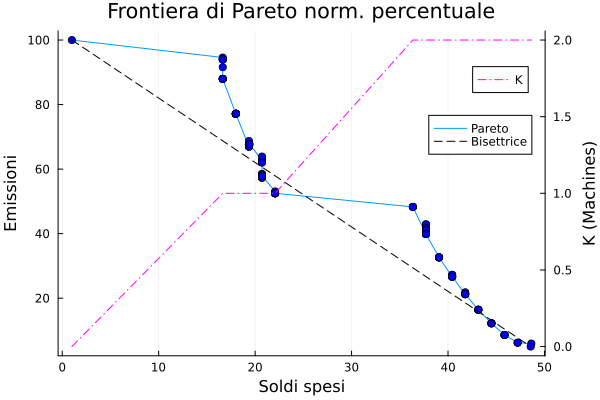

In [244]:

#stampare
x_ticks = range(0, stop=100, step=10);#
#
modified_cost = (vett_x_sm ./ minimum(vett_x_sm));
#modified_cost = log10.(vett_x_sm)
plot(modified_cost, 100*vett_y_sm/maximum(vett_y_sm),
    xlabel="Soldi spesi",
    ylabel="Emissioni",
    title="Frontiera di Pareto norm. percentuale",
    label="Pareto",
    legend= (0.85, 0.7),
    #seriestype = :scatter,
    #markersize = 5,
    #markershape = :circle,
#    xticks = (x_ticks, x_ticks),
#    yticks = (x_ticks, x_ticks)
)
# Then plot the markers on top of the line
plot!(modified_cost, 100*vett_y_sm/maximum(vett_y_sm),
    seriestype = :scatter, # This adds markers to the data points
    markersize = 4, # You can adjust the size of the markers
    markershape = :circle, # Changed to star5 for asterisk
    markercolor = :blue,  # Changed to blue
    label = "" # to avoid duplicate legend entry
)


x_first = modified_cost[1]
y_first = 100*vett_y_sm[1]/maximum(vett_y_sm)
x_last = modified_cost[end]
y_last = 100*vett_y_sm[end]/maximum(vett_y_sm)

# Plot the bisector line
plot!([x_first, x_last], [y_first, y_last],
    label="Bisettrice",
    linestyle=:dash,
    color=:black
)

# Create a secondary y-axis on the right
plot2 = twinx()

# Plot the values of K on the secondary y-axis with magenta color
plot!(plot2, modified_cost, vett_k_sm, # Using vett_k_sm
      label="K",
      ylabel="K (Machines)",
      legend= (0.94, 0.85),
      linestyle=:dashdot,
      color=:magenta) # Set color to magenta

# note, idee e spunti

* ### inserire il peso delle anime, per avere una stima migliore di quanto inquinano e per avere un calcolo del costo economico della perdita del recupero della terra da fonderia $W_{i}$
* ### che % di costi di utilizzo faccio rientrare con i finanziamenti europei?
* ### quanto impatta il recupero della terra
* ### dato un certo investimento, che effetti ha se aderiamo al progeto europeo o no
* ### se gli stampi per aima costano 3 invece di 60, che risparmio abbiamo (e quindi quanto ci conviene investire per questa ricerca)

* dati realistici
* managerial insights
* quanto costa questo adeguamento
* quanto conviene farlo (adesso first mover)

* quanto incide il discorso della terra?

# sandModel2

## Descrizione

### Ho queste variabili:
* Una variabile continua $X_{ij}$, che rappresenta il numero di anime "i = {1, ... na}" prodotte in materiale "j = {1 = organico, 2 = inorganico}.
* Una variabile intera $Y_{ij}$, che rappresenta quanti stampi ho acquistato per l'anima i in materiale j
* Una variabile binaria $Z_{ij}$ che vale 1 se attivo la produzione dell'anima i nel prodottoj, zero altrimenti
* una variabile intera $K$, che mi indica quante macchine devo adattare alla produzione di anime inorganiche

### Ho i seguenti parametri, che importo
* $Q_{ij}$ che mi dice quanto inquina un'anima i in materiale j
* $U_{ik}$ che mi indica quante anime di tipo i servono per la famiglia di prodotto k
* $P_{k}$ che mi indica quanti prodotti k produciamo k = {1...14}
* $C_{j}$ che mi indica il costo di uno stampo per un'anima di prodotto j ([3k, 60k])
* $m$ che mi indica il numero delle macchine
* $I$ mi indica quanto costa adattare una macchina oer fare stampi inorganici
* $V$ è il numero di cicli che uno stampo può durare
* $Q_{ij}$ può essere una funzione del peso $W_{i}$ (non modifica i vincoli ma solo la funzione di costo)

quindi
* $ \sum_{k} (U_{ik} \cdot P_{k}) $  mi indica la produzione richiesta per anima di tipo i, e la chiamo $P_{i}$
* $\sum_{i}(P_{i})$ la chiamo $P_{TOT}$
* $P_{TOT}/m $ sono le unità che ogni macchina produce in media in un anno. questa quantità la chiamo $M$

### funzione obiettivo: minimizzare i costi

- $ \min \left(\sum_{i}\left(\sum_{j}(\cdot C_{k} \cdot Y_{ij})\right) + I \cdot k\right)$


### Ho 4 gruppi di  vincoli:
1. Un vincolo di produzione (produco tante anime quante mi servono)

  $ X_{ij} \geq   P_{i} \cdot Z_{ij}\ \ \ \ \ \ \forall i \ \ \forall j $

2. un vincolo sul ciclo vita degli stampi

  $ X_{ij} \leq V \cdot Y_{ij} \ \ \ \ \ \ \ \ \forall i \ \ \forall j $

3. un vincolo sull'adattamento delle macchine

  $ \sum_{i}(X_{i2}) \leq k \cdot M $

4. un vincolo sull'inquinamento, con L per la combinazione convessa per Pareto

  $ \sum_{i}\left(\sum_{j}(Q_{ij} \cdot X_{ij})\right) \leq
L \cdot \sum_{i} (P_{i} \cdot Q_{i1}) + (1-L) \cdot \sum_{i} (P_{i} \cdot Q_{i2})  $



## Implementazione

Istanza 1.0      Gap: 0e+00%     K = 0.0
Istanza 0.95      Gap: 0e+00%     K = 1.0
Istanza 0.9      Gap: 0e+00%     K = 1.0
Istanza 0.85      Gap: 0e+00%     K = 1.0
Istanza 0.8      Gap: 0e+00%     K = 1.0
Istanza 0.75      Gap: 0e+00%     K = 1.0
Istanza 0.7      Gap: 0e+00%     K = 1.0
Istanza 0.65      Gap: 0e+00%     K = 1.0
Istanza 0.6      Gap: 0e+00%     K = 1.0
Istanza 0.55      Gap: 0e+00%     K = 1.0
Istanza 0.5      Gap: 0e+00%     K = 1.0
Istanza 0.45      Gap: 0e+00%     K = 2.0
Istanza 0.4      Gap: 0e+00%     K = 2.0
Istanza 0.35      Gap: 0e+00%     K = 2.0
Istanza 0.3      Gap: 0e+00%     K = 2.0
Istanza 0.25      Gap: 0e+00%     K = 2.0
Istanza 0.2      Gap: 0e+00%     K = 2.0
Istanza 0.15      Gap: 0e+00%     K = 2.0
Istanza 0.1      Gap: 0e+00%     K = 2.0
Istanza 0.05      Gap: 0e+00%     K = 2.0
Istanza 0.0      Gap: 0e+00%     K = 2.0




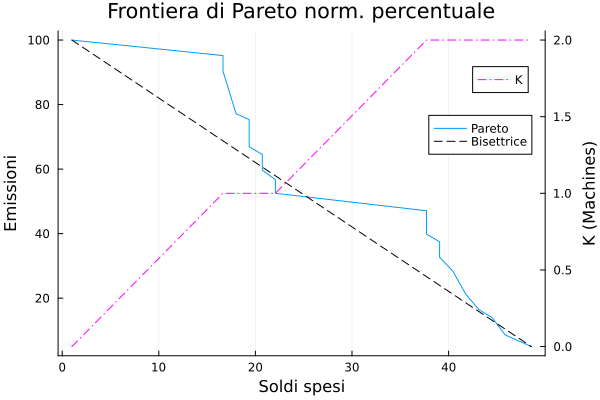

In [230]:
# import
L = 1 #peso
na = 14 #numero anime
np = 14 #numero famiglie prodotto
nm = 2 #numero materiali
m = 2#numero macchine

V = 10_000 #ciclo vita degli stampi
I = 600_000 #costo di adattamento di una macchina

C = [3000, 60000] #Cj
Q = Matrix(CSV.read("Qij.csv", DataFrame, header = false)); #Qij
U = Matrix(CSV.read("Uik.csv", DataFrame, header = false)); #Uik
p = Matrix(CSV.read("Pk.csv", DataFrame, header = false))[:,1];  #Pk

P = U * p; #così è Pi
Ptot = sum(P);
M = Ptot / m; #M produzione standard di una macchina

Yub = maximum(P)/V;
Kub = m;

#
# Stesura modello
# Definizione del modello
sandModel = Model(HiGHS.Optimizer)
set_silent(sandModel)

set_optimizer_attribute(sandModel, "mip_rel_gap", 1e-4) # Set relative MIP gap tolerance to a lower value
set_optimizer_attribute(sandModel, "presolve", "on") # Enable presolve
set_time_limit_sec(sandModel, 10.0) # Set time limit for HiGHS


# Definizione delle variabili
@variable(sandModel, X[1:na, 1:2] >= 0)  # Variabile continua
@variable(sandModel, Z[1:na, 1:2], Bin) #attivazione produzione
@variable(sandModel, 0<= Y[1:na, 1:2] <= Yub + 1, Int)  # Variabile intera positiva
@variable(sandModel, K >=0 , Int)  # Variabile intera positiva

# Vincoli
@constraint(sandModel, prod_a[i in 1:na], sum(X[i, j] for j in 1:2) >= P[i])
@constraint(sandModel, prod_b[i in 1:na, j in 1:2], X[i, j] <= P[i] * Z[i, j])
@constraint(sandModel, prodActivation[i in 1:na], sum(Z[i, j] for j in 1:2) .== 1)
@constraint(sandModel, mold[i in 1:na, j in 1:2], X[i, j] <= V * Y[i, j])
@constraint(sandModel, machine, sum(X[i, 2] for i in 1:na) <= K * M )
@constraint(sandModel, pollution, sum(Q[i, j] * X[i, j] for i in 1:na, j in 1:2) <= L * sum(P[i] * Q[i, 1] for i in 1:na) + (1 - L) * sum(P[i] * Q[i, 2] for i in 1:na))

# Funzione obiettivo
@objective(sandModel, Min, sum(C[j] * Y[i, j] for i in 1:na, j in 1:2) + I*K)

vett_y_sm = [] #qui le emissioni
vett_x_sm = [] #qui i soldi spesi
vett_k_sm = [] #qui metto le macchine

for L in 1:-0.05:0.00
  set_normalized_rhs(pollution, L * sum(P[i] * Q[i, 1] for i in 1:na) + (1 - L) * sum(P[i] * Q[i, 2] for i in 1:na))
  optimize!(sandModel)

  push!(vett_x_sm, objective_value(sandModel))
  push!(vett_y_sm, sum(Q[i, j] * value(X[i, j]) for i in 1:na, j in 1:2))
  push!(vett_k_sm, value(K))
  println("Istanza ", L, "      Gap: ", @sprintf("%.0e%%", 100 * relative_gap(sandModel)),"     K = ", value(K))
  #println("MIP gap: ", relative_gap(sandModel))
  #println("K: ", value(K))
  #println(objective_value(sandModel))
  # per bloccare il ciclo quando un modello è infeasible: "termination_status(toyModel) == MOI.INFEASIBLE"
end
println()
println()

#stampare
x_ticks = range(0, stop=100, step=10);#
#
modified_cost = (vett_x_sm ./ minimum(vett_x_sm));
#modified_cost = log10.(vett_x_sm)
plot(modified_cost, 100*vett_y_sm/maximum(vett_y_sm),
    xlabel="Soldi spesi",
    ylabel="Emissioni",
    title="Frontiera di Pareto norm. percentuale",
    label="Pareto",
    legend= (0.85, 0.7),
#    xticks = (x_ticks, x_ticks),
#    yticks = (x_ticks, x_ticks)
)

x_first = modified_cost[1]
y_first = 100*vett_y_sm[1]/maximum(vett_y_sm)
x_last = modified_cost[end]
y_last = 100*vett_y_sm[end]/maximum(vett_y_sm)

# Plot the bisector line
plot!([x_first, x_last], [y_first, y_last],
    label="Bisettrice",
    linestyle=:dash,
    color=:black
)

# Create a secondary y-axis on the right
plot2 = twinx()

# Plot the values of K on the secondary y-axis with magenta color
plot!(plot2, modified_cost, vett_k_sm, # Using vett_k_sm
      label="K",
      ylabel="K (Machines)",
      legend= (0.94, 0.85),
      linestyle=:dashdot,
      color=:magenta) # Set color to magenta